<a href="https://colab.research.google.com/github/DucAnh025/DeepLearning/blob/main/Deep_Learning_mid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
InceptionNet (GoogleNet) là một kiến trúc mạng nơ-ron tích chập (CNN) được phát triển bởi Google vào năm 2014.
Nó có nhiều phiên bản như Inception v1, v2, v3, và v4, với cấu trúc đặc biệt là Inception Module
cho phép xử lý các đặc trưng hình ảnh khác nhau bằng cách sử dụng nhiều kích thước kernel song song.
 Phiên bản Inception v3 sử dụng các cải tiến như **factorized convolutions** và **grid size reduction**,
 giúp tối ưu hiệu suất và giảm chi phí tính toán. Trong dự án này, sử dùng Inception v3 cho bài toán phân
 loại ảnh viễn thám. Inception v3 sẽ giúp trích xuất đặc trưng từ các ảnh vệ tinh và sử dụng kỹ thuật
  **transfer learning** để fine-tune mô hình đã huấn luyện trước (pre-trained) trên ImageNet,
   giúp phân loại chính xác các đối tượng như beach, airplane, forest, buildings, và tennis court.
"""

In [ ]:
!pip install torchvision matplotlib
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/dataset'

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = ImageFolder(data_dir, transform=transform)

# Chia dữ liệu thành train, val và test với tỉ lệ 70% train, 15% val, 15% test
train_data, test_data = train_test_split(dataset, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1765, random_state=42) # 0.1765 is approx 15% of the remaining 85%

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
model = models.inception_v3(pretrained=True)

# Điều chỉnh số lớp output cho phù hợp với số class trong dataset (5 classes)
model.fc = nn.Linear(model.fc.in_features, 5)

# Freeze các layer trước (không fine-tune)
for param in model.parameters():
    param.requires_grad = False

# Chỉ fine-tune fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 117MB/s] 


In [ ]:
num_epochs = 10
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [ ]:
# Khởi tạo hàm Loss CrossEntropy
criterion = nn.CrossEntropyLoss()

# Khởi tạo optimizer cho fully connected layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)  # Nhận đầu ra từ mô hình

            # Kiểm tra nếu đầu ra là InceptionOutputs
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Lấy đầu ra đầu tiên (class scores)

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        # Lưu trữ kết quả huấn luyện
        train_loss_list.append(running_loss / len(train_loader))
        train_acc_list.append(100 * correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct / total}%")

         # Đánh giá trên tập validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_running_loss += loss.item()

        val_loss_list.append(val_running_loss / len(val_loader))
        val_acc_list.append(100 * val_correct / val_total)

        print(f"Validation Loss: {val_running_loss/len(val_loader)}, Validation Accuracy: {100 * val_correct / val_total}%")

# Gọi hàm huấn luyện
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch [1/10], Loss: 1.4241650863127275, Accuracy: 42.693409742120345%
Validation Loss: 1.1003232796986897, Validation Accuracy: 75.0%
Epoch [2/10], Loss: 0.9548675905574452, Accuracy: 77.36389684813754%
Validation Loss: 0.6937107046445211, Validation Accuracy: 93.42105263157895%
Epoch [3/10], Loss: 0.6243903528560292, Accuracy: 91.11747851002865%
Validation Loss: 0.5605229139328003, Validation Accuracy: 93.42105263157895%
Epoch [4/10], Loss: 0.48344058069315826, Accuracy: 93.40974212034384%
Validation Loss: 0.42557696501413983, Validation Accuracy: 97.36842105263158%
Epoch [5/10], Loss: 0.4008571586825631, Accuracy: 93.40974212034384%
Validation Loss: 0.3596871594587962, Validation Accuracy: 98.6842105263158%
Epoch [6/10], Loss: 0.3277032443068244, Accuracy: 95.70200573065902%
Validation Loss: 0.312453289826711, Validation Accuracy: 97.36842105263158%
Epoch [7/10], Loss: 0.2776341343467886, Accuracy: 96.84813753581662%
Validation Loss: 0.28288698196411133, Validation Accuracy: 97.36842

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

# Gọi hàm đánh giá
evaluate_model(model, test_loader)

Accuracy of the model on the test images: 98.66666666666667%


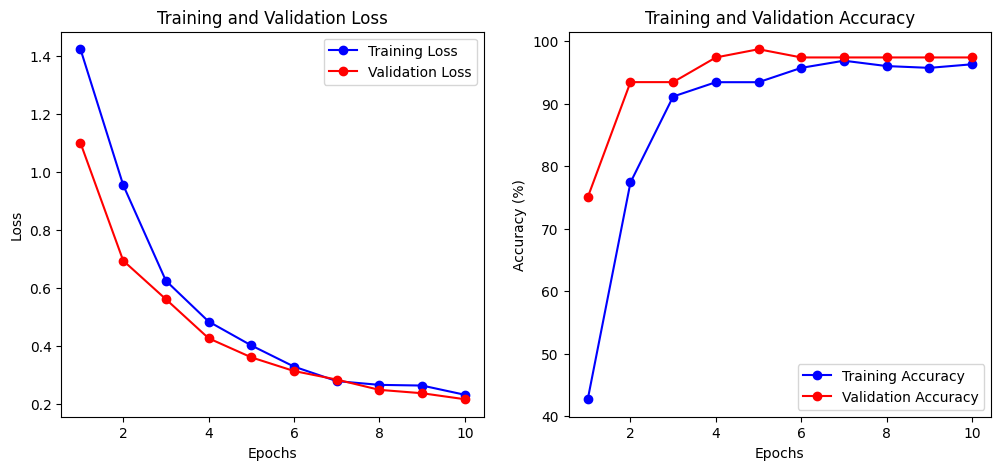

In [ ]:
# Vẽ đồ thị Loss và Accuracy
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()
    # Gọi hàm vẽ đồ thị
plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

In [ ]:
torch.save(model.state_dict(), 'inception_model.pth')
